# Prediction with a pre-trained model (PyTorch)

This notebook demonstrates how to use a pre-trained 3D U-Net model to perform fault segmentation on new seismic data. It covers two scenarios:
1.  **Simple Prediction:** Running inference on a single data cube (e.g., from the validation set) to quickly check model performance.
2.  **Complex Prediction:** Running inference on a large field data volume that is bigger than the model's input size. This requires a tiling (or patching) approach with overlapping and blending to produce a smooth, final result.

## Step 1: Import Libraries and Configure Environment

First, we import the necessary libraries and configure the GPU. This setup is identical to our training notebook to ensure consistency.

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# FIX: Import the corrected unet function from your .py file
from unet3_pytorch import * #unet

In [4]:
# --- Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)
np.random.seed(12345)

print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cuda
Device name: NVIDIA RTX A5000


## Step 2: Define Paths and Parameters

Here we define the paths to our data and the trained model. **Make sure `model_name` points to the specific `.keras` model file you want to use for prediction.**

In [5]:
# --- Base Directory (Ensure this matches your training notebook's setup) ---
base_dir = "/home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras"

# --- Data Paths ---
original_data_dir = os.path.join(base_dir, "data_from_Wu")
processed_data_dir = os.path.join(base_dir, "data_processed_npy")
validation_dir_new = os.path.join(processed_data_dir, 'validation')
prediction_dir_f3d = os.path.join(original_data_dir, "prediction/f3d") # For the large field data

# --- Model Path ---
model_dir = os.path.join(base_dir, "model")
# !!! IMPORTANT: Set the name of the model you want to load !!!
model_name = "unet_pytorch_model_200pairs_10epochs_2025-07-29_06-27-12.pth"
model_path = os.path.join(model_dir, model_name)

# --- Model Input Parameters (Must match training) ---
patch_n1, patch_n2, patch_n3 = 128, 128, 128

## Step 3: Load the Trained Model

We load the compiled model from the specified `.keras` file. Since we used a standard loss function (`binary_crossentropy`), we don't need to provide any `custom_objects`.

In [6]:
# --- Load the Model ---
print(f"Loading model from: {model_path}")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please check the path and filename.")

# FIX: Instantiate the model using the CORRECT imported function
model = unet().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Set the model to evaluation mode (very important!)

print("Model loaded successfully.")

Loading model from: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/model/unet_pytorch_model_200pairs_10epochs_2025-07-29_06-27-12.pth
Model loaded successfully.


/tmp/ipykernel_175959/2366342373.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True))
        
        self.conv1 = double_conv(in_channels, 16)
        self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = double_conv(16, 32)
        self.pool2 = nn.MaxPool3d(2, 2)
        self.conv3 = double_conv(32, 64)
        self.pool3 = nn.MaxPool3d(2, 2)
        self.conv4 = double_conv(64, 128)
        
        self.up5 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv5 = double_conv(128 + 64, 64)
        self.up6 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv6 = double_conv(64 + 32, 32)
        self.up7 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv7 = double_conv(32 + 16, 16)
        
        self.conv8 = nn.Conv3d(16, out_channels, kernel_size=1)
        
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        
        u5 = self.up5(c4)
        c5 = self.conv5(torch.cat([u5, c3], dim=1))
        u6 = self.up6(c5)
        c6 = self.conv6(torch.cat([u6, c2], dim=1))
        u7 = self.up7(c6)
        c7 = self.conv7(torch.cat([u7, c1], dim=1))
        
        return torch.sigmoid(self.conv8(c7))

## Step 4: Simple Prediction on a Validation Sample

This is a sanity check to ensure the model loads and predicts correctly. We will take one sample from the validation set, apply the *exact same* preprocessing as in training, and visualize the result.

Displaying slice 64 from validation sample 10


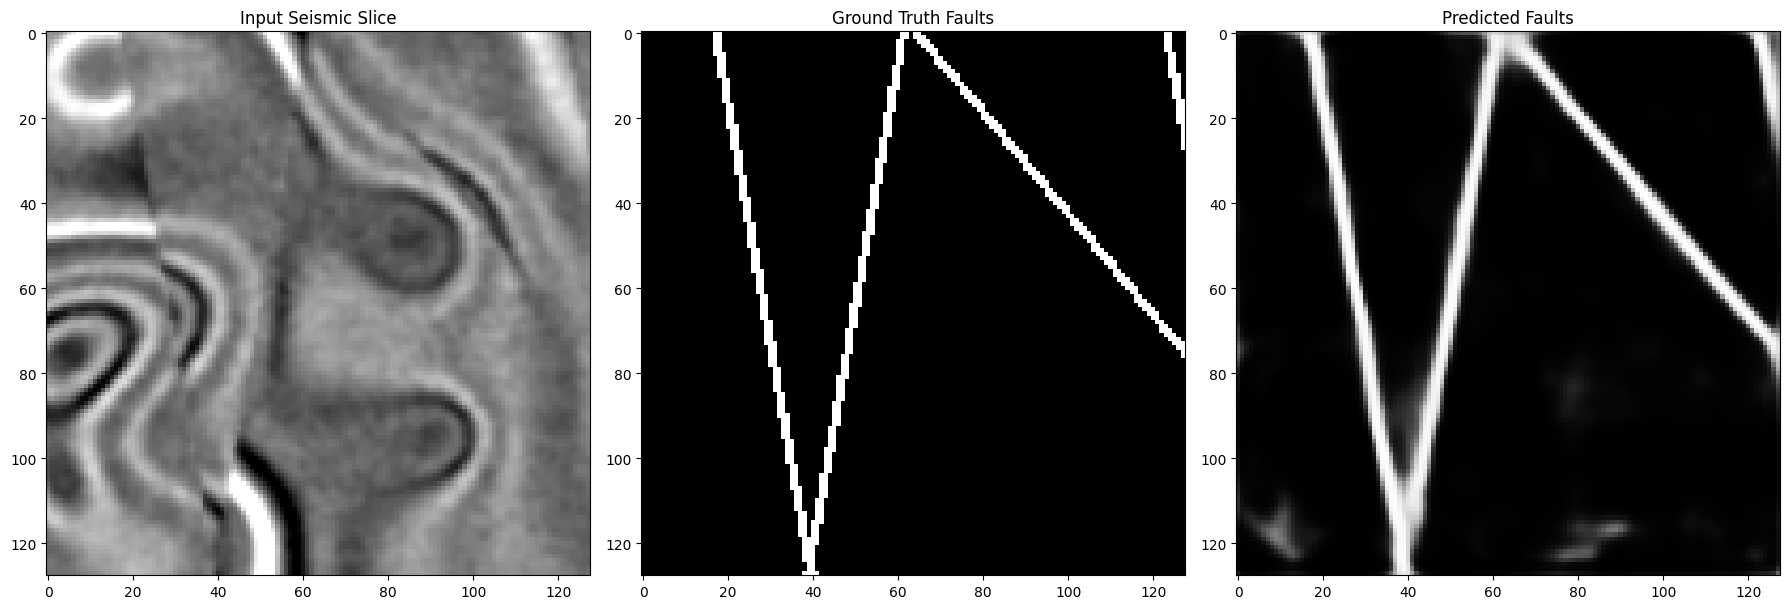

In [8]:
def plot_prediction_slices(gx_slice, fx_slice, fp_slice):
    """Plots the input, ground truth, and prediction slices side-by-side."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    ax1.set_title("Input Seismic Slice")
    ax1.imshow(gx_slice.T, cmap='gray', vmin=-2, vmax=2) # Transpose for correct viewing orientation
    
    ax2.set_title("Ground Truth Faults")
    ax2.imshow(fx_slice.T, cmap='gray', vmin=0, vmax=1)
    
    ax3.set_title("Predicted Faults")
    ax3.imshow(fp_slice.T, cmap='gray', vmin=0, vmax=1)
    
    plt.tight_layout()
    plt.show()

# --- Load a validation sample ---
sample_id = '10' # Use sample '10.npy'
gx_orig = np.load(os.path.join(validation_dir_new, 'seis', f'{sample_id}.npy'))
fx_orig = np.load(os.path.join(validation_dir_new, 'fault', f'{sample_id}.npy'))

# --- Preprocessing (MUST MATCH TRAINING) ---
gx_processed = (gx_orig - np.mean(gx_orig)) / (np.std(gx_orig) + 1e-8)
gx_transposed = np.transpose(gx_processed)
fx_transposed = np.transpose(fx_orig)

# --- Predict ---
# Convert to tensor, add batch/channel dims, and move to device
input_tensor = torch.from_numpy(gx_transposed).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float)
with torch.no_grad():
    fp_tensor = model(input_tensor)

# Convert back to numpy array for plotting
fp_transposed = fp_tensor.squeeze().cpu().numpy()

# --- Visualize a slice ---
slice_idx = 64
print(f"Displaying slice {slice_idx} from validation sample {sample_id}")
plot_prediction_slices(gx_transposed[slice_idx,:,:], fx_transposed[slice_idx,:,:], fp_transposed[slice_idx,:,:])

## Step 5: Complex Prediction on a Large Field Image (Tiling/Patching)

Real-world seismic volumes are much larger than the model's `128x128x128` input size. To handle this, we use a patch-based approach:
1.  **Padding:** The large volume is padded with zeros to ensure it's perfectly divisible by our patch-and-stride logic.
2.  **Tiling:** We slide a `128x128x128` window across the padded volume with a defined overlap.
3.  **Blending:** To avoid sharp edges in the final prediction, we use a Gaussian mask. Predictions in the center of a patch have a higher weight than those at the edges.
4.  **Stitching:** We accumulate the weighted predictions and the weights themselves. The final fault probability at each point is the sum of weighted predictions divided by the sum of weights.

In [9]:
def create_gaussian_mask(overlap_size, n1, n2, n3):
    """Creates a 3D Gaussian mask for smooth blending of patches."""
    sc = np.ones((n1, n2, n3), dtype=np.single)
    sig = overlap_size / 4.0
    sig = 0.5 / (sig * sig)
    
    sp = np.zeros(overlap_size, dtype=np.single)
    for i in range(overlap_size):
        ds = i - overlap_size + 1
        sp[i] = np.exp(-ds * ds * sig)
        
    for i in range(overlap_size):
        sc[i,:,:] *= sp[i]
        sc[n1-1-i,:,:] *= sp[i]
        sc[:,i,:] *= sp[i]
        sc[:,n2-1-i,:] *= sp[i]
        sc[:,:,i] *= sp[i]
        sc[:,:,n3-1-i] *= sp[i]
    return sc

# --- 1. Load Large Seismic Volume ---
f3d_path = os.path.join(prediction_dir_f3d, 'gxl.dat')
m3, m2, m1 = 512, 384, 128
gx = np.fromfile(f3d_path, dtype=np.single).reshape(m3, m2, m1)
print(f"Loaded F3 field data with shape: {gx.shape}")

# --- FIX: Transpose to (xline, inline, depth) to match training data orientation ---
gx = np.transpose(gx)
m1, m2, m3 = gx.shape
print(f"Transposed shape for processing: {gx.shape}")

# --- 2. Setup Tiling Parameters ---
# FIX: Renamed 'os' to 'overlap_size' to avoid conflict with the os module
overlap_size = 12
stride = (patch_n1 - overlap_size, patch_n2 - overlap_size, patch_n3 - overlap_size)

# Calculate padding needed
p1 = (stride[0] - (m1 - patch_n1) % stride[0]) % stride[0] if m1 > patch_n1 else 0
p2 = (stride[1] - (m2 - patch_n2) % stride[1]) % stride[1] if m2 > patch_n2 else 0
p3 = (stride[2] - (m3 - patch_n3) % stride[2]) % stride[2] if m3 > patch_n3 else 0
gp = np.pad(gx, ((0,p1), (0,p2), (0,p3)), mode='constant', constant_values=0)
padded_shape = gp.shape

# --- 3. Initialize Output and Run Prediction Loop ---
gy = np.zeros(padded_shape, dtype=np.single)
mk = np.zeros(padded_shape, dtype=np.single)
sc = create_gaussian_mask(overlap_size, patch_n1, patch_n2, patch_n3)

k1_range = range(0, padded_shape[0] - patch_n1 + 1, stride[0])
k2_range = range(0, padded_shape[1] - patch_n2 + 1, stride[1])
k3_range = range(0, padded_shape[2] - patch_n3 + 1, stride[2])

print("\nStarting tiling prediction on large volume...")
for k1 in tqdm(k1_range, desc="Dim 1/3"):
    for k2 in k2_range:
        for k3 in k3_range:
            patch = gp[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3]
            
            # FIX: Use mean/std normalization PER PATCH to match training
            patch_processed = (patch - np.mean(patch)) / (np.std(patch) + 1e-8)
            
            input_patch = torch.from_numpy(patch_processed).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float)
            with torch.no_grad():
                predicted_patch_tensor = model(input_patch)
            
            predicted_patch = predicted_patch_tensor.squeeze().cpu().numpy()
            
            gy[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3] += predicted_patch * sc
            mk[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3] += sc

# --- 4. Finalize by Averaging and Cropping ---
gy = np.divide(gy, mk, out=np.zeros_like(gy), where=mk!=0)
fp_final_transposed = gy[:m1, :m2, :m3]

print(f"\nPrediction complete. Final fault probability map shape: {fp_final_transposed.shape}")

output_filename = os.path.join(prediction_dir_f3d, "fp_pytorch.dat")
fp_final_transposed.astype(np.single).tofile(output_filename)
print(f"Final prediction saved to: {output_filename}")

Loaded F3 field data with shape: (512, 384, 128)
Transposed shape for processing: (128, 384, 512)

Starting tiling prediction on large volume...


Dim 1/3:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction complete. Final fault probability map shape: (128, 384, 512)
Final prediction saved to: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_Wu_2019_Keras/data_from_Wu/prediction/f3d/fp_pytorch.dat


## Step 6: Visualize the Field Prediction Results

Now we can load the original seismic data and our final fault prediction to compare them visually on different slices.

Seismic data shape for plotting: (512, 384, 128)
Prediction data shape for plotting: (512, 384, 128)


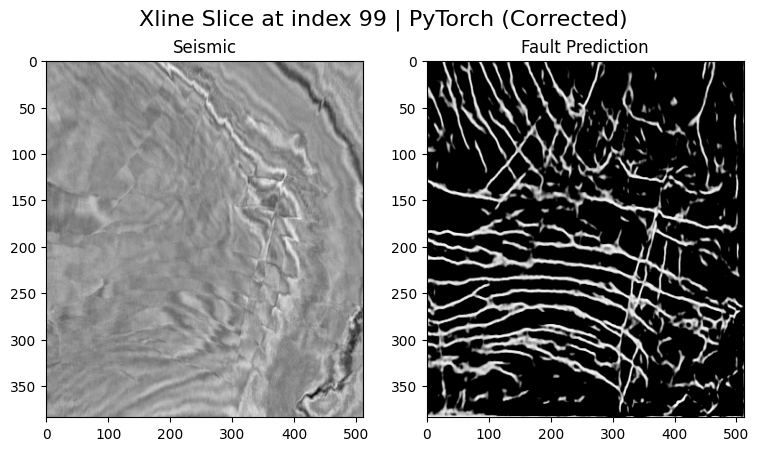

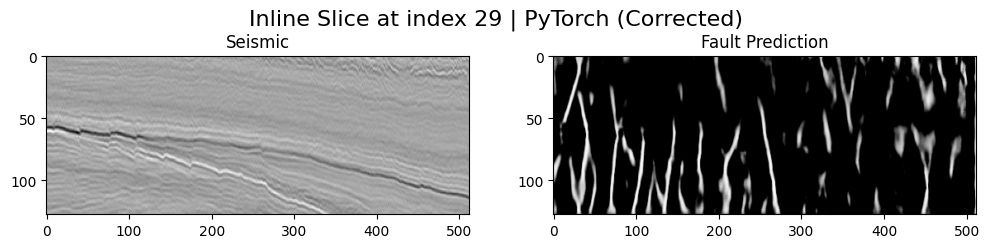

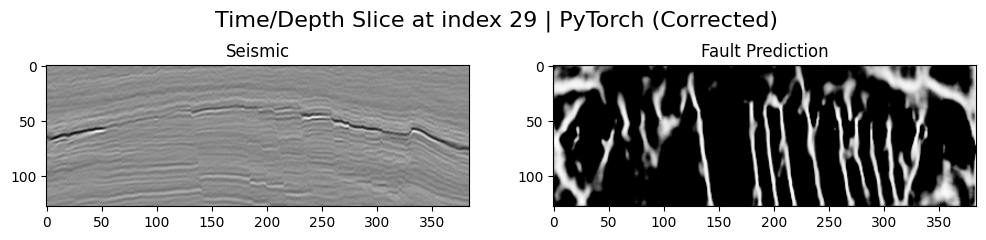

In [10]:
# --- 1. Reload Data in Original Orientation ---
m3, m2, m1 = 512, 384, 128 

seismic_path = os.path.join(prediction_dir_f3d, 'gxl.dat')
gx_orig_view = np.fromfile(seismic_path, dtype=np.single).reshape(m3, m2, m1)

prediction_path = os.path.join(prediction_dir_f3d, "fp_pytorch.dat")
fp_transposed = np.fromfile(prediction_path, dtype=np.single).reshape(m1, m2, m3)
fp_orig_view = np.transpose(fp_transposed)

print(f"Seismic data shape for plotting: {gx_orig_view.shape}")
print(f"Prediction data shape for plotting: {fp_orig_view.shape}")


# --- 2. Define Slice Indices (from original notebook) ---
k1_depth, k2_inline, k3_xline = 29, 29, 99


# --- 3. Plot Each Slice Type in a Separate Figure ---

# --- Xline Slice ---
gx_slice = gx_orig_view[:, :, k3_xline]
fp_slice = fp_orig_view[:, :, k3_xline]
fig = plt.figure(figsize=(9, 9))
plt.suptitle(f'Xline Slice at index {k3_xline} | PyTorch (Corrected)', fontsize=16, y=0.75)
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), aspect=1.5, cmap=plt.cm.gray)
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), aspect=1.5, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()


# --- Inline Slice ---
gx_slice = gx_orig_view[:, k2_inline, :]
fp_slice = fp_orig_view[:, k2_inline, :]
fig = plt.figure(figsize=(12, 12))
plt.suptitle(f'Inline Slice at index {k2_inline} | PyTorch (Corrected)', fontsize=16, y=0.6)
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), aspect=1.5, cmap=plt.cm.gray)
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), aspect=1.5, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()


# --- Time/Depth Slice ---
gx_slice = gx_orig_view[k1_depth, :, :]
fp_slice = fp_orig_view[k1_depth, :, :]
fig = plt.figure(figsize=(12, 12))
plt.suptitle(f'Time/Depth Slice at index {k1_depth} | PyTorch (Corrected)', fontsize=16, y=0.6)
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), cmap=plt.cm.gray)
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()